## Name: Ken Jin Chan
## Student ID: 45689768
## Portfolio url: https://github.com/MQCOMP2200-S2-2020/portfolio-2020-Ken-Jin05

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import collections
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


[nltk_data] Downloading package stopwords to C:\Users\hp
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


In [2]:
# Binary Classification (2 classes)
# Multi-class Classification
# Multi-label Classification

## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [3]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [4]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape


(8954, 5)

In [5]:
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


In [6]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()


,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## Feature Exaction

Now you take over to build a suitable model and present your results.

Firstly, you need to perform feature extraction to produce feature vectors for the predictive models.

## Label Encoding

In [7]:
le = preprocessing.LabelEncoder()
le.fit(list(genre_books['genre'].values))

LabelEncoder()

In [8]:
list(le.classes_)

["Children's literature", 'Fantasy', 'Mystery', 'Novel', 'Science Fiction']

In [9]:
# create new column
genre_books['genre_no'] = le.transform(list(genre_books['genre']))

In [10]:
genre_books.head()

,title,author,date,summary,genre,genre_no
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,0
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,3
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,3
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,1
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1


In [11]:
target_names = list(le.inverse_transform([0, 1, 2, 3, 4]))
target_names

["Children's literature", 'Fantasy', 'Mystery', 'Novel', 'Science Fiction']

## TfIdfVectorizer

In [12]:
book_summary = genre_books['summary']

### min_df means the word must show up at least that many times

In [13]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words = stopwords.words('english'), min_df = 5)
x = vectorizer.fit_transform(book_summary).toarray()
x.shape

(8954, 5000)

## Model Training

Then, train two predictive models from the given data set.

## Split into train and test 

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, genre_books['genre_no'], test_size = 0.2, random_state = 142)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7163, 5000)
(7163,)
(1791, 5000)
(1791,)


## Logistic Regression

In [15]:
lr = LogisticRegression(solver = 'sag')
lr.fit(x_train, y_train)

LogisticRegression(solver='sag')

In [16]:
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)

In [17]:
print("Scores on training set")
print(classification_report(y_train, y_train_pred_lr, target_names = target_names))

Scores on training set
                       precision    recall  f1-score   support

Children's literature       0.86      0.73      0.79       855
              Fantasy       0.86      0.87      0.87      1858
              Mystery       0.91      0.83      0.87      1125
                Novel       0.80      0.88      0.84      1828
      Science Fiction       0.84      0.85      0.85      1497

             accuracy                           0.85      7163
            macro avg       0.85      0.83      0.84      7163
         weighted avg       0.85      0.85      0.85      7163



In [18]:
print("Scores on testing set")
print(classification_report(y_test, y_test_pred_lr, target_names = target_names))

Scores on testing set
                       precision    recall  f1-score   support

Children's literature       0.69      0.46      0.55       237
              Fantasy       0.72      0.77      0.74       453
              Mystery       0.74      0.64      0.69       271
                Novel       0.60      0.76      0.67       430
      Science Fiction       0.74      0.69      0.71       400

             accuracy                           0.69      1791
            macro avg       0.70      0.66      0.67      1791
         weighted avg       0.69      0.69      0.68      1791



[Text(0, 0.5, "Children's literature"),
 Text(0, 1.5, 'Fantasy'),
 Text(0, 2.5, 'Mystery'),
 Text(0, 3.5, 'Novel'),
 Text(0, 4.5, 'Science Fiction')]

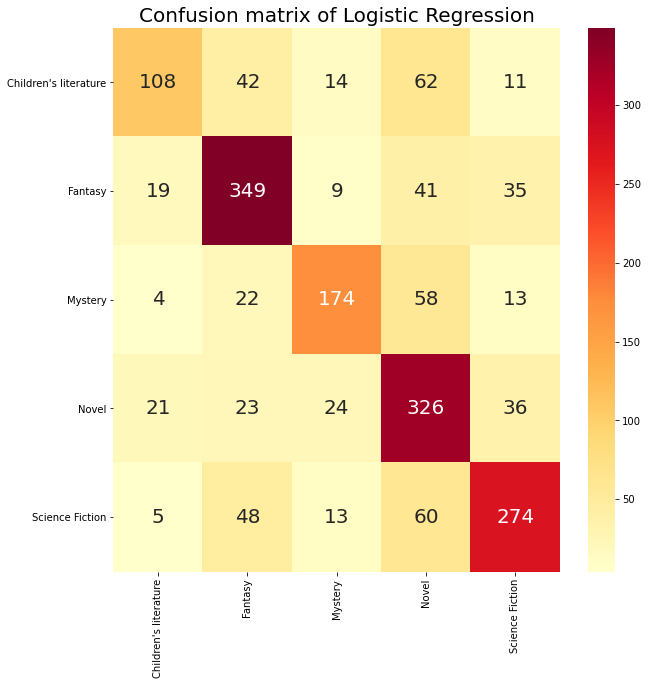

In [19]:
cm = confusion_matrix(y_test, y_test_pred_lr)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d',annot_kws={"size": 20}, cmap = 'YlOrRd')

# ticks and title
ax.set_title('Confusion matrix of Logistic Regression', fontsize = 20)
ax.xaxis.set_ticklabels(["Children's literature", "Fantasy", "Mystery", "Novel", "Science Fiction"], rotation = 90)
ax.yaxis.set_ticklabels(["Children's literature", "Fantasy", "Mystery", "Novel", "Science Fiction"], rotation = 0)

From here we can see the number of books being predicted correctly and wrongly.
- Children's literature has 108/867 correctly predicted.
- Fantasy has 349/583 correctly predicted.
- Mystery has 174/331 correctly predicted.
- Novel has 326/561 correctly predicted.
- Science Fiction has 274/495 correctly predicted.

# K-neighbour

In [20]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [21]:
y_train_pred_knn = knn.predict(x_train)
y_test_pred_knn = knn.predict(x_test)

In [22]:
print("Scores on training set")
print(classification_report(y_train, y_train_pred_knn, target_names = target_names))

Scores on training set
                       precision    recall  f1-score   support

Children's literature       0.58      0.19      0.29       855
              Fantasy       0.29      0.98      0.44      1858
              Mystery       0.86      0.21      0.34      1125
                Novel       0.82      0.07      0.13      1828
      Science Fiction       0.86      0.09      0.16      1497

             accuracy                           0.35      7163
            macro avg       0.68      0.31      0.27      7163
         weighted avg       0.67      0.35      0.27      7163



In [23]:
print("Scores on testing set")
print(classification_report(y_test, y_test_pred_knn, target_names = target_names))

Scores on testing set
                       precision    recall  f1-score   support

Children's literature       0.50      0.08      0.14       237
              Fantasy       0.27      0.97      0.42       453
              Mystery       0.81      0.16      0.27       271
                Novel       0.59      0.04      0.08       430
      Science Fiction       0.94      0.07      0.13       400

             accuracy                           0.31      1791
            macro avg       0.62      0.27      0.21      1791
         weighted avg       0.61      0.31      0.22      1791



[Text(0, 0.5, "Children's literature"),
 Text(0, 1.5, 'Fantasy'),
 Text(0, 2.5, 'Mystery'),
 Text(0, 3.5, 'Novel'),
 Text(0, 4.5, 'Science Fiction')]

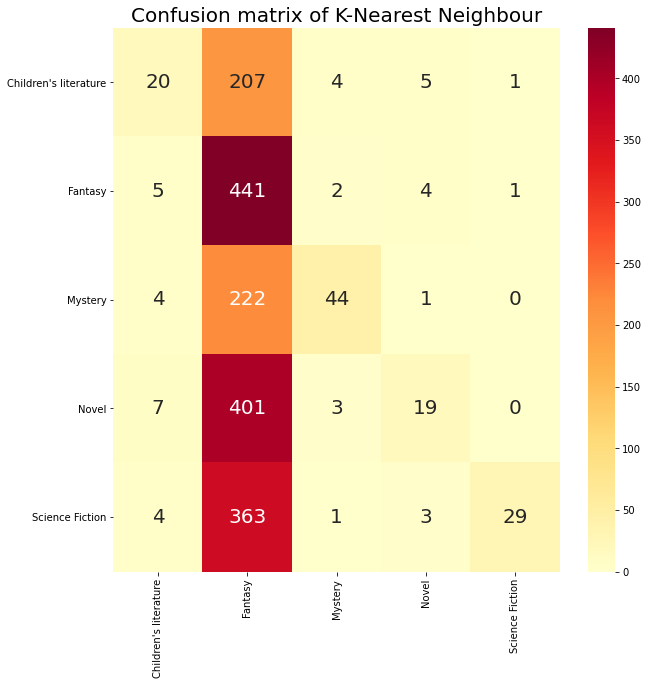

In [24]:
cm = confusion_matrix(y_test, y_test_pred_knn)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d',annot_kws={"size": 20}, cmap = 'YlOrRd')

# ticks
ax.set_title('Confusion matrix of K-Nearest Neighbour', fontsize = 20)
ax.xaxis.set_ticklabels(["Children's literature", "Fantasy", "Mystery", "Novel", "Science Fiction"], rotation = 90)
ax.yaxis.set_ticklabels(["Children's literature", "Fantasy", "Mystery", "Novel", "Science Fiction"], rotation = 0)

From here we can see the number of books being predicted correctly and wrongly.
- Children's literature has 20/257 correctly predicted.
- Fantasy has 441/1646 correctly predicted.
- Mystery has 44/281 correctly predicted.
- Novel has 19/443 correctly predicted.
- Science Fiction has 29/402 correctly predicted.

## Random Forest Classifier

In [25]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [26]:
y_train_pred_rfc = rfc.predict(x_train)
y_test_pred_rfc = rfc.predict(x_test)

In [27]:
print("Scores on training set")
print(classification_report(y_train, y_train_pred_rfc, target_names = target_names))

Scores on training set
                       precision    recall  f1-score   support

Children's literature       1.00      1.00      1.00       855
              Fantasy       1.00      1.00      1.00      1858
              Mystery       1.00      1.00      1.00      1125
                Novel       1.00      1.00      1.00      1828
      Science Fiction       1.00      1.00      1.00      1497

             accuracy                           1.00      7163
            macro avg       1.00      1.00      1.00      7163
         weighted avg       1.00      1.00      1.00      7163



In [28]:
print("Scores on testing set")
print(classification_report(y_test, y_test_pred_rfc, target_names = target_names))

Scores on testing set
                       precision    recall  f1-score   support

Children's literature       0.67      0.31      0.42       237
              Fantasy       0.64      0.77      0.70       453
              Mystery       0.69      0.58      0.63       271
                Novel       0.58      0.72      0.64       430
      Science Fiction       0.73      0.68      0.71       400

             accuracy                           0.65      1791
            macro avg       0.66      0.61      0.62      1791
         weighted avg       0.66      0.65      0.64      1791



[Text(0, 0.5, "Children's literature"),
 Text(0, 1.5, 'Fantasy'),
 Text(0, 2.5, 'Mystery'),
 Text(0, 3.5, 'Novel'),
 Text(0, 4.5, 'Science Fiction')]

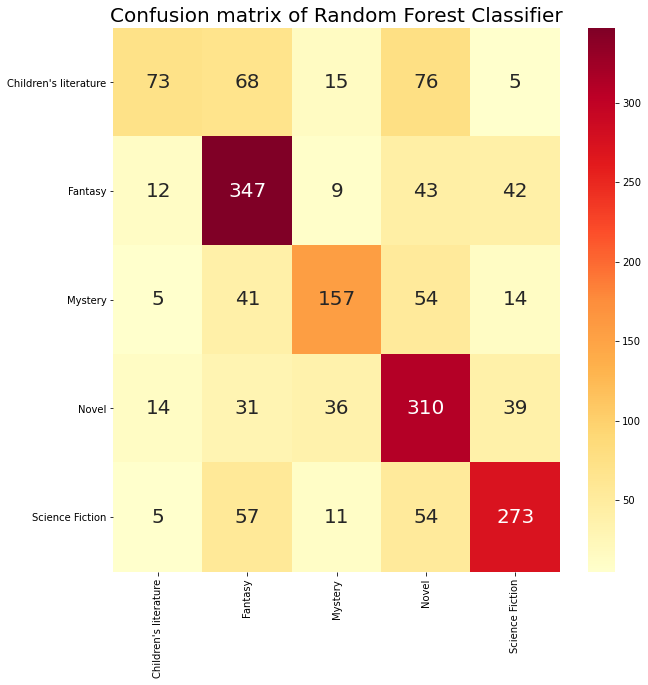

In [29]:
cm = confusion_matrix(y_test, y_test_pred_rfc)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d',annot_kws={"size": 20}, cmap = 'YlOrRd')

# ticks and title
ax.set_title('Confusion matrix of Random Forest Classifier', fontsize = 20)
ax.xaxis.set_ticklabels(["Children's literature", "Fantasy", "Mystery", "Novel", "Science Fiction"], rotation = 90)
ax.yaxis.set_ticklabels(["Children's literature", "Fantasy", "Mystery", "Novel", "Science Fiction"], rotation = 0)

From here we can see the number of books being predicted correctly and wrongly.
- Children's literature has 74/279 correctly predicted.
- Fantasy has 336/640 correctly predicted.
- Mystery has 163/332 correctly predicted.
- Novel has 311/670 correctly predicted.
- Science Fiction has 277/500 correctly predicted.

## Gaussian Naive Bayes

In [30]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [31]:
y_train_pred_gnb = gnb.predict(x_train)
y_test_pred_gnb = gnb.predict(x_test)

In [32]:
print("Scores on training set")
print(classification_report(y_train, y_train_pred_gnb, target_names = target_names))

Scores on training set
                       precision    recall  f1-score   support

Children's literature       0.64      0.99      0.78       855
              Fantasy       0.96      0.72      0.83      1858
              Mystery       0.78      0.91      0.84      1125
                Novel       0.88      0.69      0.77      1828
      Science Fiction       0.79      0.90      0.84      1497

             accuracy                           0.81      7163
            macro avg       0.81      0.84      0.81      7163
         weighted avg       0.84      0.81      0.81      7163



In [33]:
print("Scores on testing set")
print(classification_report(y_test, y_test_pred_gnb, target_names = target_names))

Scores on testing set
                       precision    recall  f1-score   support

Children's literature       0.42      0.47      0.44       237
              Fantasy       0.69      0.59      0.64       453
              Mystery       0.51      0.55      0.53       271
                Novel       0.47      0.47      0.47       430
      Science Fiction       0.60      0.63      0.62       400

             accuracy                           0.55      1791
            macro avg       0.54      0.54      0.54      1791
         weighted avg       0.55      0.55      0.55      1791



[Text(0, 0.5, "Children's literature"),
 Text(0, 1.5, 'Fantasy'),
 Text(0, 2.5, 'Mystery'),
 Text(0, 3.5, 'Novel'),
 Text(0, 4.5, 'Science Fiction')]

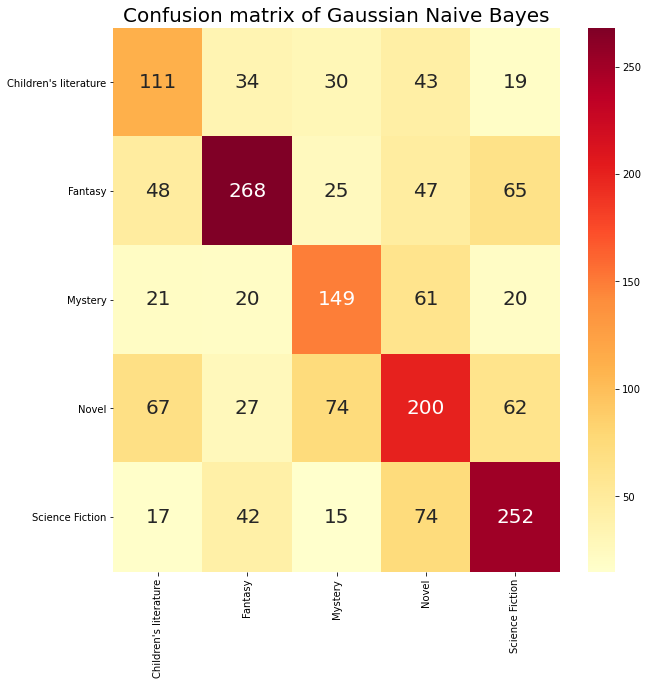

In [34]:
cm = confusion_matrix(y_test, y_test_pred_gnb)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d',annot_kws={"size": 20}, cmap = 'YlOrRd')

# ticks and title
ax.set_title('Confusion matrix of Gaussian Naive Bayes', fontsize = 20)
ax.xaxis.set_ticklabels(["Children's literature", "Fantasy", "Mystery", "Novel", "Science Fiction"], rotation = 90)
ax.yaxis.set_ticklabels(["Children's literature", "Fantasy", "Mystery", "Novel", "Science Fiction"], rotation = 0)

From here we can see the number of books being predicted correctly and wrongly.
- Children's literature has 111/390 correctly predicted.
- Fantasy has 268/576 correctly predicted.
- Mystery has 149/415 correctly predicted.
- Novel has 200/655 correctly predicted.
- Science Fiction has 252/566 correctly predicted.

## Model Evaluation

Finally, evaluate and compare the learned predictive models.

In [35]:
models=[]
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier(n_estimators = 100)))
models.append(('GNB', GaussianNB()))

In [36]:
results = []
model_names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10,random_state=12)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    model_names.append(name)
    message = "%s: %f" % (name, cv_results.mean())
    print(message)

LR: 0.690772
KNN: 0.309083
RFC: 0.643164
GNB: 0.540837


## Model choosing based on accuracy
From here, we can see that the best model to use is Logistic Regression with an accuracy score of 0.70 followed by Random Forest Classifier with an accuraccy score of 0.65 then Gaussian Naive Bayes with an accuracy score of 0.54 and lastly the worst model to use is K-Nearest Neighbor with an accuracy score of 0.31.

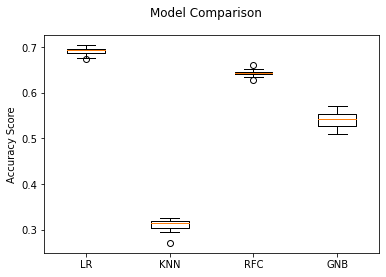

In [37]:
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(model_names)
ax.set_ylabel('Accuracy Score')
plt.show()

From the boxplot above, we can visually conclude that the best model is Logistic Regression followed by Random Forest then Gaussian Naive Bayes then lastly K-Nearest Neighbor.